# Weather Only Model

## Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS
from scipy.stats import gaussian_kde, skew, kurtosis

## Functions

In [2]:
def train_fe(file_path_SM_hist):
    '''
    given the file path from the preious jupyter notebooks, outputs the model 
    inputs
    - the file path of yearly aggregated feols regressors
    outputs
    - fips_level_inputs_pd as the clean dataset
    '''
    fips_level_inputs_pd = pd.read_csv(file_path_SM_hist) 
    fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
    fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
    fips_level_inputs_pd['year2'] = fips_level_inputs_pd['year']**2
    fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
    fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)
    return fips_level_inputs_pd

def eff_se_for_m(m):
    d = pd.Series(0.0, index=results_h21.params.index)
    d['SoilM_0_100cm'] = (m - m0) / number_of_days
    d['SoilM_0_100cm_square']  = (m*m - m0*m0) / number_of_days
    
    if SQUARE_IS_MEAN_OF_SQUARES:
        # this is the case sm was square before mean 
        d['SoilM_0_100cm_square'] = ((m**2) - (m0**2)) / number_of_days
    else:
        # this is the case of sm was mean before squaring
        d['SoilM_0_100cm_square'] = 2.0 * m0 * d['SoilM_0_100cm']
        
    b  = results_h21.params.reindex(d.index).fillna(0.0).values
    theta = covariance.reindex(index=d.index, columns=d.index).fillna(0.0).values
    x  = d.values
    eff = 100.0 * float(x @ b)
    se  = 100.0 * float(np.sqrt(x @ theta @ x))
    return eff, se

def futureYield(file_pattern_i, results_h21_yield, fixed_effects_no_time_unique_yield):
    '''
    Given a file path of yearly aggregated regressors calculates future corn yield projections 
    This function must be ran after the model is trained on the historical period (as done above with haqiqi et al method)
    inputs
    - file_pattern_i which is the path to the file path we are interested in (this comes from script 6)
    - results_h21_yield which is model specfic params 
    - fixed_effects_no_time_unique_yield which is model specific fixed effects
    outputs
    - pandas dataframe which includes fips and year as multi-index and prediction as column (of log corn yield)
    - pattern_name_i which is a cleaned pattern name corresponding to the future projections
    '''
    pattern_name = file_pattern_i.split("/")[-1]
    single_model = pd.read_csv(file_pattern_i)
    single_model['fips'] = single_model['fips'].astype(str).str.zfill(5)
    single_model['state'] = single_model['fips'].astype(str).str.slice(0, 2)
    single_model['year_input'] = single_model['year'].astype(float)
    single_model['year2'] = (single_model['year']**2).astype(float)
    single_model['SoilM_0_100cm_square'] = single_model['SoilM_0_100cm']**2
    # this is distinct and important to only retain valid states 
    single_model = single_model[single_model['fips'].isin(valid_fips)]
    single_model = single_model.set_index(['fips', 'year'])
    # we now go through each column multiplying it by its respective \beta_{i}
    new_predictions_no_effects = results_h21_yield.predict(data=single_model, effects=True)
    new_predictions_no_effects = new_predictions_no_effects.reset_index('year') # predictions
    merged_df_predictions_fixed = pd.merge(new_predictions_no_effects, fixed_effects_no_time_unique_yield, on='fips', how='inner')
    merged_df_predictions_fixed['total_pred'] = merged_df_predictions_fixed['predictions'] + merged_df_predictions_fixed['estimated_effects']
    merged_df_predictions_fixed = merged_df_predictions_fixed.reset_index()
    merged_df_predictions_fixed = merged_df_predictions_fixed.set_index(['fips', 'year'])
    return merged_df_predictions_fixed, pattern_name

def scalarYield(df_prediction_timespace, year, fips_code):
    '''
    Given df (like that of futureYield with fips, year, column), return the scalar corn yield for 
    certain combination of year and fips location
    '''
    return df_prediction_timespace.loc[fips_code, year]['total_pred'].item()

def weatherShocks(name_i, predictions_i, df_set_index_i, label_i, hist_mean_exist=False):
    '''
    Given inputs / outputs for the econometric function haqiqi 2a, outputs the weather shocks i.e. the 
    haqiqi 2a model without the time trend and state level fixed effects, while also demeaning at the county level to give 
    essentially the weather contribution to the yield
    inputs:
    name_i as the string of the input specifics (i.e. model, nldas product ...) 
    results_h21_i as the results of the model
    predictions_i as the predictions of the model from the fit 
    df_set_index_i as the input i.e. the training dataset 
    label_i as the nldas soil moisture product for which the shocks are measured against. 
    outputs:
    weather_fit as the nonshock contribution
    weather_shock as the weather shocks
    '''
    if label_i == 'VIC':
        integer_index = 0
    elif label_i == 'NOAH':
        integer_index = 1
    elif label_i == 'MOS' or label_i == 'MOSAIC':
        integer_index = 2
        
    params = results_h21_arr[integer_index].params
    log_yield = results_h21_arr[integer_index].model.dependent
    estimate_effects = predictions_i['estimated_effects'].loc[fips_number]
    total_pred_series = predictions_i['total_pred'].loc[fips_number]
    valid_years  = predictions_i.loc[fips_number].index.values
    valid_years2 = valid_years**2
    yearcoeff = params[f'C(state)[T.{state_number}]:year_input'].item()
    year2coeff = params[f'C(state)[T.{state_number}]:year2'].item()
    time_trend = valid_years * yearcoeff + valid_years2 * year2coeff
    weather_fit = total_pred_series - time_trend - estimate_effects
    if hist_mean_exist == False:
        historical_mean = weather_fit.mean()
    elif hist_mean_exist == True:
        historical_mean = historicalWeatherMean(label_i)
    weather_shock = weather_fit - historical_mean
    return weather_fit, weather_shock

def historicalWeatherMean(label_i):
    '''
    given a nldas soil moisture string (MOS, VIC, NOAH) gives the weather fit for the historial perio.
    previously it was calculate the wf_arr are contains the historical fits.  wf_arr is in shape of sm_labels which is sm_labels = ['VIC', 'NOAH', 'MOSAIC']
    inputs
    - label_i as the nldas soil moisture string
    outputs
    - historical_mean as the mean 
    '''
    if label_i == 'VIC':
        historical_mean = wf_arr[0].mean()
    elif label_i == 'NOAH':
        historical_mean = wf_arr[1].mean()
    elif label_i == 'MOS' or label_i == 'MOSAIC':
        historical_mean = wf_arr[2].mean()
    else:
        raise ValueError("Unexpected string when computing historical_mean")
    return historical_mean

def plot_kernel(time_frames):
    '''
    helper function to just plot the kernel density for n time frames
    input
    - time_frames as array 
    output
    - plot of n time_frames densities
    '''
    #time_frames = ["2045-2074"]
    ssps = ['ssp245', 'ssp370']
    #color_arr = ['#1f77b4', '#2ca02c', '#9467bd']
    #color_arr = ['#ff7f0e','#d62728', '#8c564b']
    color_arr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for time_frame in time_frames:
        color_count = 0
        unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})
        
        fips_code = '17113'
        plt.figure(figsize=(8,4))
        plt.title(f"Distribution Weather Shocks {time_frame} (H21, L21) \n fips = {fips_number}", fontsize=16)
        plt.xlabel("Log Corn Yields", fontsize=14)
        plt.ylabel("Probability Density", fontsize=14)
        for indx, label_i in enumerate(sm_labels):
            
            for ssp_i in ssps:
                time_series_list_for_maxnmin = []
                for model_name_i in unique_model_names:
                    corresponding_year_for_model_i_time_series = []
                    model_name_i_time_series = []
                    all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_{time_frame}_ddaysm.csv"))
                    for file_pattern_i in all_pattern_245:
                        df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                        weather_fit, weather_shock = weatherShocks(pattern_name, df_predictions_future, df_set_index_i, label_i, hist_mean_exist=True)
                        #plt.plot(weather_shock)
                        time_series_list_for_maxnmin.append(weather_shock)
        
                time_series_list_for_maxnmin = np.concatenate(time_series_list_for_maxnmin).astype(float)
                xs = np.linspace(-1.75, 0.25, 400)
                kde = gaussian_kde(time_series_list_for_maxnmin)
                plt.plot(xs, kde(xs), color=color_arr[color_count], label=f'{ssp_i} {label_i}', lw=2)
                color_count += 1
            
            plt.legend(fontsize=16)

## Preprocessing similar to 6_implementation_2a.ipynb

In [3]:
csv_output_file_haqiqi2021_2aVIC = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/VIC_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aNOAH = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/NOAH_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aMOS = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/MOS_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"

usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"

sm_labels = ['VIC', 'NOAH', 'MOSAIC']

In [4]:
counties = gpd.read_file(county_shp_path)
usda_pd = pd.read_csv(usda_filepath)
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]
# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')
# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]
usda_pd['log_yield'] = np.log(usda_pd['yield'])

In [5]:
fips_level_inputs_pd_VIC = train_fe(csv_output_file_haqiqi2021_2aVIC)
fips_level_inputs_pd_NOAH = train_fe(csv_output_file_haqiqi2021_2aNOAH)
fips_level_inputs_pd_MOS = train_fe(csv_output_file_haqiqi2021_2aMOS)
list_historic_sm = [fips_level_inputs_pd_VIC, fips_level_inputs_pd_NOAH, fips_level_inputs_pd_MOS]
df_set_index_arr = []
# merge usda_pd & histdata 
for soil_moisture_comibination_i in list_historic_sm:
    
    df = soil_moisture_comibination_i.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
    df['year2'] = df['year']**2
    
    rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                       "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                       "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                       "46", "47", "48", "50", "51", "54", "55"]
    
    df = df[df['state'].isin(rainfed_states)]
    df_set_index = df.set_index(['fips', 'year'])
    df_set_index_arr.append(df_set_index) # the arr of dataframes is ordered by the list_historic (so VIC then NOAH then MOS)

## Weather Only Component (Lafferty 2021 esque)
### $logY'_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{\alpha}EDD_{binned} $
- We only want this component, and subtract off time trend and state fe
- This is showing the 'weather' component of the yield model, which is then demeaned.
- This demeaned plot is showing the yearly contribution of weather towards the yield (i.e. with no technological trend or state level fixed effects)

In [6]:
# define the model with compound extremes & state specific trends

formula = (
    'log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + '
    'edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + '
    'C(state):year_input + C(state):year2 + EntityEffects'
)

model_arr = []
results_h21_arr = []
predictions_arr = []
for df_set_index_i in df_set_index_arr:
    model = PanelOLS.from_formula(formula, data=df_set_index_i)
    results_h21 = model.fit(cov_type='clustered', clusters=df_set_index_i['state'])
    predictions = results_h21.predict(effects=True)
    predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']
    model_arr.append(model)
    results_h21_arr.append(results_h21)
    predictions_arr.append(predictions)

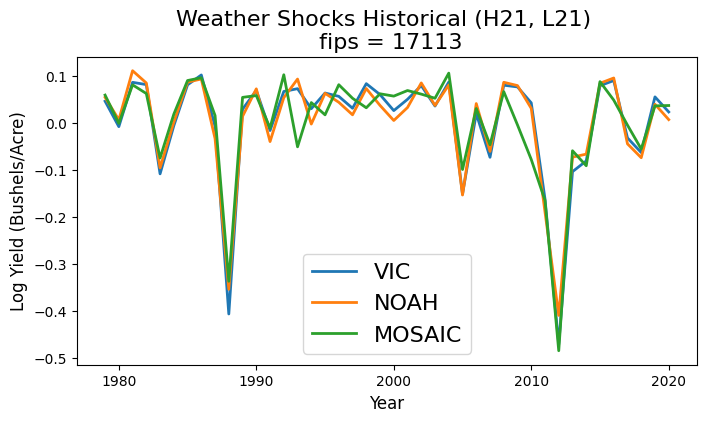

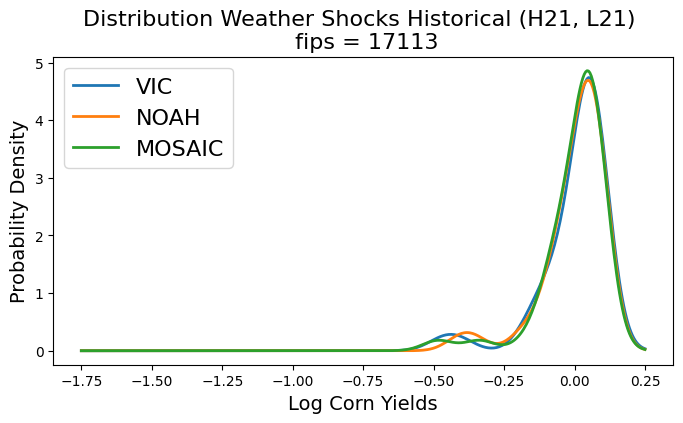

In [20]:
fips_number = '17113'
state_number = fips_number[:2]
plt.figure(figsize=(8,4))
plt.title(f'Weather Shocks Historical (H21, L21) \n fips = {fips_number}', fontsize=16)
ws_arr = []
wf_arr = []
for (name_i, predictions_i, df_set_index_i) in zip(sm_labels, predictions_arr, df_set_index_arr):
    
    weather_fit, weather_shock = weatherShocks(name_i, predictions_i, df_set_index_i, name_i, hist_mean_exist=False)
    ws_arr.append(weather_shock)
    wf_arr.append(weather_fit)
    plt.plot(weather_shock, label=name_i, lw=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Log Yield (Bushels/Acre)', fontsize=12)
plt.legend(fontsize=16)
plt.show()
plt.figure(figsize=(8,4))
for (name_i, weather_shock_i) in zip(sm_labels, ws_arr):
    xs = np.linspace(-1.75, 0.25, 400)
    kde = gaussian_kde(weather_shock_i)
    plt.plot(xs, kde(xs), label=name_i, lw=2)

plt.title(f"Distribution Weather Shocks Historical (H21, L21) \n fips = {fips_number}", fontsize=16)
plt.xlabel("Log Corn Yields", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.legend(fontsize=16)

### Future projections 

In [8]:
csv_output_file = f"/storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/"
# arbritrary path looks like /storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/ACCESS-CM2_r1i1p1f1_ssp245_VIC_kge_2015-2044_ddaysm.csv 
all_pattern_370_VIC = sorted(glob.glob(f"{csv_output_file}*_ssp370_VIC_kge_2015-2044_ddaysm.csv"))
all_pattern_245_VIC = sorted(glob.glob(f"{csv_output_file}*_ssp245_VIC_kge_2015-2044_ddaysm.csv"))
all_pattern_370_NOAH = sorted(glob.glob(f"{csv_output_file}*_ssp370_NOAH_kge_2015-2044_ddaysm.csv"))
all_pattern_245_NOAH = sorted(glob.glob(f"{csv_output_file}*_ssp245_NOAH_kge_2015-2044_ddaysm.csv"))
all_pattern_370_MOS = sorted(glob.glob(f"{csv_output_file}*_ssp370_MOS_kge_2015-2044_ddaysm.csv"))
all_pattern_245_MOS = sorted(glob.glob(f"{csv_output_file}*_ssp245_MOS_kge_2015-2044_ddaysm.csv"))

# get fixed effects from the intial model run (above) 
fixed_effects_no_time_unique_arr, valid_fips_arr = [], []
for indx, results_h21_i in enumerate(results_h21_arr):
    fixed_effects_by_fips = results_h21_i.estimated_effects
    fixed_effects_no_time = fixed_effects_by_fips.reset_index(['fips', 'year']).drop('year', axis=1).drop_duplicates()
    fixed_effects_no_time_unique = fixed_effects_no_time.drop_duplicates(subset='fips', keep='first')
    fixed_effects_no_time_unique = fixed_effects_no_time_unique.set_index('fips')
    valid_fips = df_set_index.index.get_level_values('fips').unique()
    fixed_effects_no_time_unique_arr.append(fixed_effects_no_time_unique)
    valid_fips_arr.append(valid_fips)

## Time Series

In [ ]:
time_frames = ["2015-2044", "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
#color_arr = ['#1f77b4', '#2ca02c', '#9467bd']
color_arr = ['#ff7f0e','#d62728', '#8c564b']

color_count = 0
unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

fips_code = '17113'
plt.figure(figsize=(8,4))
plt.title(f"Weather Shocks Future (H21, L21) \n fips = {fips_number}", fontsize=16)
plt.ylabel("Log Corn Yields", fontsize=14)
plt.xlabel("Year", fontsize=14)

for indx, label_i in enumerate(sm_labels):
    
    for ssp_i in ssps[1:]:
        time_series_list_for_maxnmin = []
        for model_name_i in unique_model_names:
            corresponding_year_for_model_i_time_series = []
            model_name_i_time_series = []
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_*.csv"))
            for file_pattern_i in all_pattern_245:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                weather_fit, weather_shock = weatherShocks(pattern_name, df_predictions_future, df_set_index_i, label_i, hist_mean_exist=True)
                #plt.plot(weather_shock)
                model_name_i_time_series.append(weather_shock)
                corresponding_year_for_model_i_time_series.append(weather_shock.index)
                
            if corresponding_year_for_model_i_time_series and model_name_i_time_series:
                
                combined_years = np.concatenate(corresponding_year_for_model_i_time_series)
                combined_time_series = np.concatenate(model_name_i_time_series)
    
                # resort to make sure no issues when concatinating
                sort_idx = np.argsort(combined_years)
                combined_years = combined_years[sort_idx]
                combined_time_series = combined_time_series[sort_idx]
                
                time_series_list_for_maxnmin.append(combined_time_series)
                del corresponding_year_for_model_i_time_series, model_name_i_time_series, combined_time_series
                #plt.plot(combined_years, combined_time_series, alpha=0.05, color=color)
    
        ssp_ensemble_mean = np.mean(time_series_list_for_maxnmin, axis=0)
        ninetyseven_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 97.5, axis=0)
        two_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 2.5, axis=0)
        plt.fill_between(combined_years, ninetyseven_pt5_percentile, two_pt5_percentile, color=color_arr[color_count], alpha=0.2, label=f'{ssp_i} {label_i}')
        plt.ylim(-1.75, 0.25)
        plt.plot(combined_years, ssp_ensemble_mean, color=color_arr[color_count], alpha=0.8)
        color_count += 1
    
    plt.legend(fontsize=16)

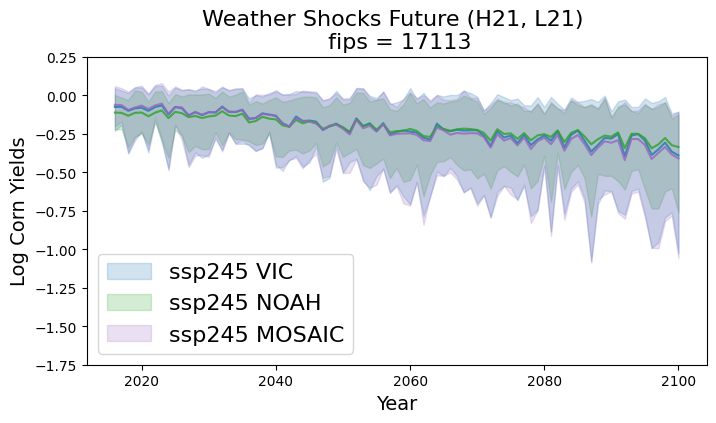

In [9]:
time_frames = ["2015-2044", "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
#color_arr = ['#1f77b4', '#2ca02c', '#9467bd']
color_arr = ['#1f77b4', '#2ca02c', '#9467bd']

color_count = 0
unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

fips_code = '17113'
plt.figure(figsize=(8,4))
plt.title(f"Weather Shocks Future (H21, L21) \n fips = {fips_number}", fontsize=16)
plt.ylabel("Log Corn Yields", fontsize=14)
plt.xlabel("Year", fontsize=14)

for indx, label_i in enumerate(sm_labels):
    
    for ssp_i in ssps[:1]:
        time_series_list_for_maxnmin = []
        for model_name_i in unique_model_names:
            corresponding_year_for_model_i_time_series = []
            model_name_i_time_series = []
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_*.csv"))
            for file_pattern_i in all_pattern_245:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                weather_fit, weather_shock = weatherShocks(pattern_name, df_predictions_future, df_set_index_i, label_i, hist_mean_exist=True)
                #plt.plot(weather_shock)
                model_name_i_time_series.append(weather_shock)
                corresponding_year_for_model_i_time_series.append(weather_shock.index)
                
            if corresponding_year_for_model_i_time_series and model_name_i_time_series:
                
                combined_years = np.concatenate(corresponding_year_for_model_i_time_series)
                combined_time_series = np.concatenate(model_name_i_time_series)
    
                # resort to make sure no issues when concatinating
                sort_idx = np.argsort(combined_years)
                combined_years = combined_years[sort_idx]
                combined_time_series = combined_time_series[sort_idx]
                
                time_series_list_for_maxnmin.append(combined_time_series)
                del corresponding_year_for_model_i_time_series, model_name_i_time_series, combined_time_series
                #plt.plot(combined_years, combined_time_series, alpha=0.05, color=color)
    
        ssp_ensemble_mean = np.mean(time_series_list_for_maxnmin, axis=0)
        ninetyseven_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 97.5, axis=0)
        two_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 2.5, axis=0)
        plt.fill_between(combined_years, ninetyseven_pt5_percentile, two_pt5_percentile, color=color_arr[color_count], alpha=0.2, label=f'{ssp_i} {label_i}')
        plt.ylim(-1.75, 0.25)
        plt.plot(combined_years, ssp_ensemble_mean, color=color_arr[color_count], alpha=0.8)
        color_count += 1
    
    plt.legend(fontsize=16)

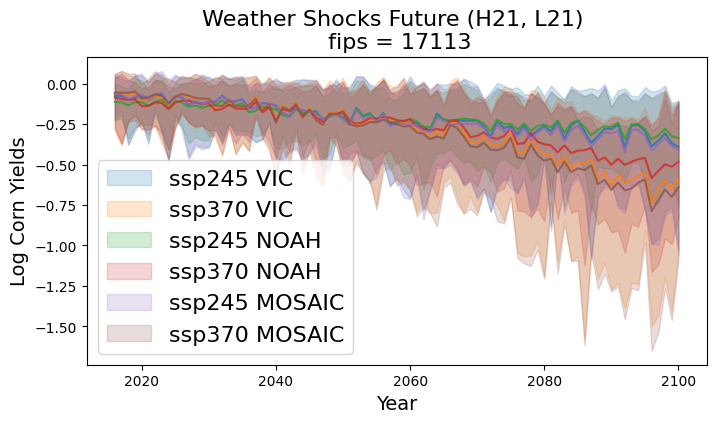

In [11]:
time_frames = ["2015-2044", "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
#color_arr = ['#1f77b4', '#2ca02c', '#9467bd']
color_arr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

color_count = 0
unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

fips_code = '17113'
plt.figure(figsize=(8,4))
plt.title(f"Weather Shocks Future (H21, L21) \n fips = {fips_number}", fontsize=16)
plt.ylabel("Log Corn Yields", fontsize=14)
plt.xlabel("Year", fontsize=14)

for indx, label_i in enumerate(sm_labels):
    
    for ssp_i in ssps:
        time_series_list_for_maxnmin = []
        for model_name_i in unique_model_names:
            corresponding_year_for_model_i_time_series = []
            model_name_i_time_series = []
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_*.csv"))
            for file_pattern_i in all_pattern_245:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                weather_fit, weather_shock = weatherShocks(pattern_name, df_predictions_future, df_set_index_i, label_i, hist_mean_exist=True)
                #plt.plot(weather_shock)
                model_name_i_time_series.append(weather_shock)
                corresponding_year_for_model_i_time_series.append(weather_shock.index)
                
            if corresponding_year_for_model_i_time_series and model_name_i_time_series:
                
                combined_years = np.concatenate(corresponding_year_for_model_i_time_series)
                combined_time_series = np.concatenate(model_name_i_time_series)
    
                # resort to make sure no issues when concatinating
                sort_idx = np.argsort(combined_years)
                combined_years = combined_years[sort_idx]
                combined_time_series = combined_time_series[sort_idx]
                
                time_series_list_for_maxnmin.append(combined_time_series)
                
                del corresponding_year_for_model_i_time_series, model_name_i_time_series, combined_time_series
                #plt.plot(combined_years, combined_time_series, alpha=0.05, color=color)
    
        ssp_ensemble_mean = np.mean(time_series_list_for_maxnmin, axis=0)
        ninetyseven_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 97.5, axis=0)
        two_pt5_percentile = np.percentile(time_series_list_for_maxnmin, 2.5, axis=0)
        plt.fill_between(combined_years, ninetyseven_pt5_percentile, two_pt5_percentile, color=color_arr[color_count], alpha=0.2, label=f'{ssp_i} {label_i}')
        plt.plot(combined_years, ssp_ensemble_mean, color=color_arr[color_count], alpha=0.8)
        color_count += 1
    
    plt.legend(fontsize=16)

## distributions

In [9]:
time_frames = ["2015-2044", "2045-2074", "2075-2100"]

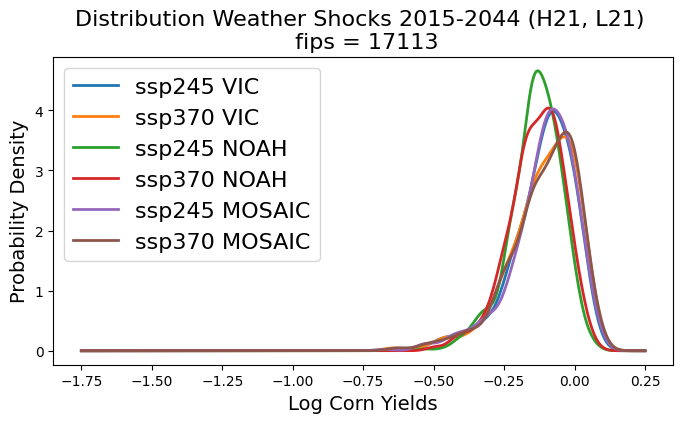

In [11]:
plot_kernel(time_frames[:1])

In [ ]:
plot_kernel(time_frames[1:2])

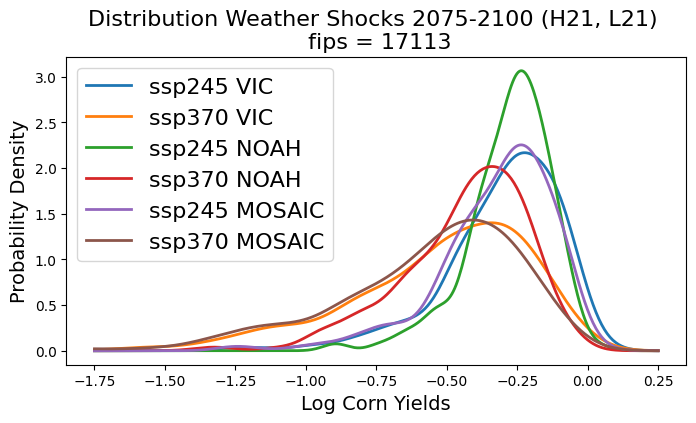

In [10]:
plot_kernel(time_frames[2:])

## Next

## Calculation of Response Curve
- Response curve for regressors
1. load picking max / min tmp soil moisture, or scalar field of interest
2. winsorize
3. calculate county level response curves
4. aggregate over us, results in triple curve on one plot with uncertainty, also show the spatial like ronak patels (tapio phd student) paper
- Might be incorrect, do not put too much stake into this. 

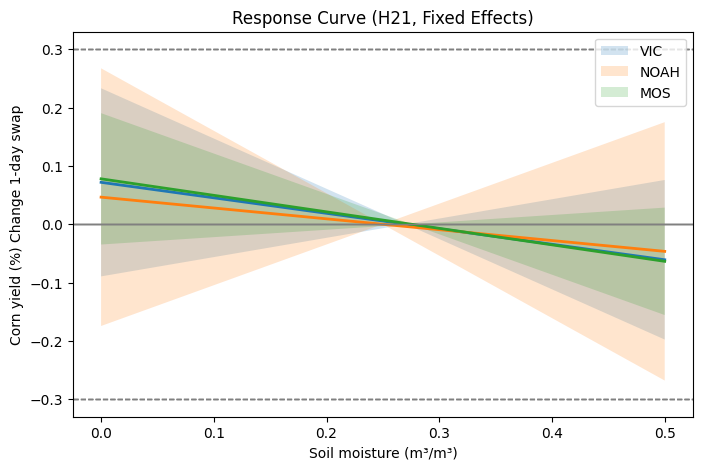

In [9]:
maxS = 0.5
minS = 0.0
number_of_days = 183
SQUARE_IS_MEAN_OF_SQUARES = False
name_list_arr =['VIC', 'NOAH', 'MOS']
plt.figure(figsize=(8,5))

for (name_i, model_i, results_h21_i, predictions_i, df_set_index_i) in zip(name_list_arr, model_arr, results_h21_arr, predictions_arr, df_set_index_arr):
    
    covariance = results_h21_i.cov
    param_dict = dict(results_h21_i.params)
    soilM_param = param_dict['SoilM_0_100cm']
    soilM2_param = param_dict['SoilM_0_100cm_square']
    
    m0 = df_set_index_i['SoilM_0_100cm'].mean()
    m_grid = np.linspace(minS*1000, maxS*1000, 1000)
    pct, se = zip(*[eff_se_for_m(m) for m in m_grid])
    pct, se = np.array(pct), np.array(se)
    lo, hi = pct - 1.96*se, pct + 1.96*se
    
    plt.plot(m_grid/1000, pct, lw=2)
    plt.fill_between(m_grid/1000, lo, hi, alpha=0.2, label=name_i)
    plt.axhline(0, lw=1, color='gray')
    plt.axhline(.3, lw=1, ls='--', color='gray')
    plt.axhline(-.3, lw=1, ls='--', color='gray')
    plt.xlabel('Soil moisture (m³/m³)')
    plt.ylabel('Corn yield (%) Change 1-day swap')
    plt.title('Response Curve (H21, Fixed Effects)')

plt.legend()